In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from sklearn.preprocessing import LabelEncoder
from geopy.geocoders import Yandex
from geopy.distance import vincenty
from time import time
from tqdm import tqdm

In [2]:
train = pd.read_csv('data/train_set.csv')
test = pd.read_csv('data/test_set.csv')

train.rename(columns={ 'pos_adress_lat' : 'pos_address_lat', 
                       'pos_adress_lon' : 'pos_address_lon'}, inplace=True)

D:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (1,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (1,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Удалить транзакции, где нет адреса координат atm, pos и terminal_id (в трейне это все строчки, где нет terminal_id)
train.drop(train[train['terminal_id'].isnull() == True].index, axis=0, inplace=True)

###########################################################################################
# Подсчет частот адресов
atm_address_count = train['atm_address'].value_counts()

# Удаление транзакций с atm_address = "RADNAYA\             RUS,445" (по нему координат нет)
# train.drop(train[train['atm_address'] == atm_address_count.index[45]].index, axis=0, inplace=True)

# Замена 'Подольск, ул. Полевановская, д. 9, (Заезд с ул. Орджоникидзе д. 25)' на 'Подольск, ул. Полевановская, д. 9'
train['atm_address'].replace(to_replace=atm_address_count.index[46], value='Подольск, ул. Полевановская, д. 9', inplace=True)

############################################################################################
# Адреса с '\' в названии (частоты)
backslash_atm_address_count = train['atm_address'][train['atm_address'].str.contains("\\\\") == True].value_counts()

# Замены до частоты 100 более-менее читаемых адресов
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[1], value='улица Маросейка, 3/13с1, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[9], value='улица Савушкина, 141, Санкт-Петербург', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[12], value='Новомытищинский проспект, 34, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[14], value='проспект Большевиков, 18, Санкт-Петербург', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[15], value='Марксистская улица, 1, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[16], value='Гражданский проспект, 41к2, Санкт-Петербург', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[18], value='улица Грекова, 8, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[23], value='Ракетный бульвар, 16, Москва', inplace=True)
train['atm_address'].replace(to_replace=backslash_atm_address_count.index[27], value='Новочеркасский проспект, 43/17, Санкт-Петербург', inplace=True)

# Остальные удалить
train.drop(train[train['atm_address'].str.contains("\\\\") == True].index, inplace=True)

############################################################################################
# Для удобства анализа сделаю labelencoding на customer_id и terminal_id
label_encoder = LabelEncoder()
train['customer_id'] = label_encoder.fit_transform(train['customer_id'])
train['terminal_id'] = label_encoder.fit_transform(train['terminal_id'])

#############################################################################################
# Обнуление NaN адресов atm и pos
train[['atm_address', 'atm_address_lat', 'atm_address_lon',
       'pos_address', 'pos_address_lat', 'pos_address_lon']] = train[['atm_address', 'atm_address_lat', 'atm_address_lon', 
                                                                      'pos_address', 'pos_address_lat', 'pos_address_lon']].fillna(0)
#######################################################################################################

# у 13 pos адресов координаты разные - исправляем
wrong_pos_address = []
with open('pos_address.txt', 'r') as file:
    for line in file:
        wrong_pos_address.append(line.strip())
        
geolocator = Yandex()

#0
location = geolocator.geocode('B. KAMENSCHIKI, 4MOSCOW')
#pos = train[train['pos_address'] == wrong_pos_address[0]]
#pos = pos.groupby(['pos_address_lat', 'pos_address_lon']).size().reset_index().rename(columns={0:'count'})

train['pos_address_lat'][train['pos_address'] == wrong_pos_address[0]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[0]] = location.longitude

#1
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[1]] = 59.2243102
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[1]] = 39.8657153

#2 под вопросом, потому что обе точки имеют место быть
#train['pos_address_lat'][train['pos_address'] == wrong_pos_address[2]] = 55.7955715
#train['pos_address_lon'][train['pos_address'] == wrong_pos_address[2]] = 37.5937033

#3 
# тоже обе точки могут быть

#4
location = geolocator.geocode("5-1A, SUSCHEVSKIY VALMOSKVA")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[4]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[4]] = location.longitude

#5
location = geolocator.geocode("'KOMMUNISTICHESKAYA STR 1MYTISCHY")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[5]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[5]] = location.longitude

#6
location = geolocator.geocode("MIRA STR 51MYTISCHY")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[6]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[6]] = location.longitude

#7
location = geolocator.geocode("42, SCHUKINSKAYA MOSKVA")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[7]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[7]] = location.longitude

#8
#нормальная, отличие в 8 незначящем знаке

#9
location = geolocator.geocode("2, VETERANOV MYTISCHI")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[9]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[9]] = location.longitude

#10
location = geolocator.geocode("55 BOLSHOY SAMPSONIEVSKIY PR SANKT-PETERBURG")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[10]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[10]] = location.longitude

#11
location = geolocator.geocode("20 BOLSHOY SAMPSONIEVSKIY PRSANKT-PETERBURG")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[11]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[11]] = location.longitude

#12
location = geolocator.geocode("Счастливая улица, 11, Усады")
train['pos_address_lat'][train['pos_address'] == wrong_pos_address[12]] = location.latitude
train['pos_address_lon'][train['pos_address'] == wrong_pos_address[12]] = location.longitude

D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [215]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265470 entries, 0 to 1265469
Data columns (total 14 columns):
amount              1265470 non-null float64
atm_address         1265470 non-null object
atm_address_lat     1265470 non-null float64
atm_address_lon     1265470 non-null float64
city                1265462 non-null object
country             1265470 non-null object
currency            1265469 non-null float64
customer_id         1265470 non-null int64
mcc                 1265470 non-null object
pos_address         1265470 non-null object
pos_address_lat     1265470 non-null float64
pos_address_lon     1265470 non-null float64
terminal_id         1265454 non-null object
transaction_date    1265469 non-null object
dtypes: float64(6), int64(1), object(7)
memory usage: 135.2+ MB


In [214]:
# test
# Обнуление NaN адресов atm и pos
test[['atm_address', 'atm_address_lat', 'atm_address_lon',
       'pos_address', 'pos_address_lat', 'pos_address_lon']] = test[['atm_address', 'atm_address_lat', 'atm_address_lon', 
                                                                      'pos_address', 'pos_address_lat', 'pos_address_lon']].fillna(0)

# Для удобства анализа сделаю labelencoding на customer_id и terminal_id
label_encoder = LabelEncoder()
test['customer_id'] = label_encoder.fit_transform(test['customer_id'])
test['terminal_id'] = label_encoder.fit_transform(test['terminal_id'])

TypeError: '>' not supported between instances of 'str' and 'float'

### Перевод адресов atm в координаты

In [5]:
# игрушечный пример
toy_train = train[:1000].copy()

сначала нужно удалить нули

In [8]:
toy_train[toy_train['atm_address'] == 0].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=1000)

In [9]:
toy_train.drop(toy_train[toy_train['atm_address'] == 0].index, inplace=True)

In [12]:
toy_train

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon


In [29]:
train[:1000000][train['atm_address'] != 0]

D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
942660,3.290224,"Москва, ул. Таганская, д. 17-23",55.744,37.663,MOSKVA,RUS,643.0,6750,55.659,37.502,6011,0,0.0,0.0,8,2017-08-15,NaN,NaN
942661,4.256019,"Москва, ул. Таганская, д. 17-23",55.741,37.665,MOSKVA,RUS,643.0,6470,55.824,37.804,6011,0,0.0,0.0,8,2017-06-27,55.741,37.664
942662,4.402484,"Москва, ул. Таганская, д. 17-23",55.741,37.667,MOSKVA,RUS,643.0,6470,55.824,37.804,6011,0,0.0,0.0,8,2017-11-02,55.741,37.664
942663,3.601407,"Москва, ул. Таганская, д. 17-23",55.743,37.662,MOSKVA,RUS,643.0,6470,55.824,37.804,6011,0,0.0,0.0,8,2017-02-10,55.741,37.664
942664,4.154766,"Москва, ул. Таганская, д. 17-23",55.742,37.668,MOSKVA,RUS,643.0,6750,55.659,37.502,6011,0,0.0,0.0,8,2017-03-24,NaN,NaN
942665,3.706789,"Москва, ул. Таганская, д. 17-23",55.737,37.667,MOSKVA,RUS,643.0,6470,55.824,37.804,6011,0,0.0,0.0,8,2017-07-03,55.741,37.664
942666,3.292168,"Москва, ул. Таганская, д. 17-23",55.744,37.666,MOSKVA,RUS,643.0,6470,55.824,37.804,6011,0,0.0,0.0,8,2017-06-29,55.741,37.664
942667,3.993990,"Москва, ул. Таганская, д. 17-23",55.737,37.663,MOSKVA,RUS,643.0,6750,55.659,37.502,6011,0,0.0,0.0,8,2017-08-30,NaN,NaN
942668,3.306480,"Москва, ул. Таганская, д. 17-23",55.740,37.664,MOSKVA,RUS,643.0,6750,55.659,37.502,6011,0,0.0,0.0,8,2017-06-20,NaN,NaN
942669,3.942296,"Москва, ул. Таганская, д. 17-23",55.741,37.664,MOSKVA,RUS,643.0,6750,55.659,37.502,6011,0,0.0,0.0,8,2017-04-10,NaN,NaN


быстро глянем на записи, где нет pos и нет адреса atm

In [32]:
train[(train['pos_address'] == 0) & (train['pos_address_lat'] == 0) & (train['atm_address'] == 0) & (train['atm_address_lat'] != 0)][:10]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
943982,3.599656,0,59.216,39.929,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-11-03,55.777,37.592
943986,3.616697,0,59.214,39.931,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-09-20,55.777,37.592
943987,3.618929,0,59.218,39.933,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-10-05,55.777,37.592
943989,3.601462,0,59.218,39.935,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-09-03,55.777,37.592
943990,3.611839,0,59.216,39.932,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-07-15,55.777,37.592
943991,3.580642,0,59.214,39.936,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-11-17,55.777,37.592
943992,3.581383,0,59.213,39.936,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-08-07,55.777,37.592
943993,3.599418,0,59.218,39.936,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-08-31,55.777,37.592
943994,3.715576,0,59.216,39.934,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-06-05,55.777,37.592
944004,3.126007,0,59.808,30.165,ST.PETERSBURG,RU,643.0,8887,59.832,30.153,6011,0,0.0,0.0,1052,2017-09-09,59.940,30.318


In [38]:
# Транзакции, где нет адреса atm, но есть координаты
no_atm_address = train[(train['atm_address'] == 0) & (train['atm_address_lat'] != 0)]
print(no_atm_address.shape)
no_atm_address[:10]

(2482, 18)


,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
943982,3.599656,0,59.216,39.929,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-11-03,55.777,37.592
943986,3.616697,0,59.214,39.931,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-09-20,55.777,37.592
943987,3.618929,0,59.218,39.933,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-10-05,55.777,37.592
943989,3.601462,0,59.218,39.935,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-09-03,55.777,37.592
943990,3.611839,0,59.216,39.932,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-07-15,55.777,37.592
943991,3.580642,0,59.214,39.936,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-11-17,55.777,37.592
943992,3.581383,0,59.213,39.936,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-08-07,55.777,37.592
943993,3.599418,0,59.218,39.936,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-08-31,55.777,37.592
943994,3.715576,0,59.216,39.934,VOLOGDA,RU,643.0,2065,59.228,39.874,6011,0,0.0,0.0,1019,2017-06-05,55.777,37.592
944004,3.126007,0,59.808,30.165,ST.PETERSBURG,RU,643.0,8887,59.832,30.153,6011,0,0.0,0.0,1052,2017-09-09,59.940,30.318


In [45]:
terminal = no_atm_address['terminal_id'].unique()
print(len(terminal))
terminal[:10]

459


array([1019, 1052, 1095, 1141, 1613, 1641, 1721, 1785, 2618, 2741], dtype=int64)

In [48]:
no_atm_address['city'][no_atm_address['terminal_id'] == terminal[0]].unique()[0]

'VOLOGDA      '

In [59]:
atm = no_atm_address[no_atm_address['terminal_id'] == terminal[1]]
atm

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
944004,3.126007,0,59.808,30.165,ST.PETERSBURG,RU,643.0,8887,59.832,30.153,6011,0,0.0,0.0,1052,2017-09-09,59.94,30.318


In [54]:
atm['atm_address_lat'][atm['atm_address_lat'].index[0]]

59.216000000000001

In [62]:
terminal = no_atm_address['terminal_id'].value_counts()
terminal = terminal[:10]
terminal

191128    131
103576    119
147692    111
22383     108
161837    100
1785       88
86105      85
140387     81
44622      59
135729     50
Name: terminal_id, dtype: int64

In [66]:
terminal.index[0]

191128

In [77]:
city = no_atm_address['city'][no_atm_address['terminal_id'] == terminal.index[8]].unique()[8]

IndexError: index 8 is out of bounds for axis 0 with size 1

In [262]:
c = 3
city = no_atm_address['city'][no_atm_address['terminal_id'] == terminal.index[c]].unique()[0]
location = geolocator.geocode(city)

m = folium.Map(location=[location.latitude, location.longitude], zoom_start=10)
atm = no_atm_address[no_atm_address['terminal_id'] == terminal.index[c]]
#folium.Marker([location.latitude, location.longitude], popup='<i>True</i>', icon=folium.Icon(color='red', icon='font')).add_to(m)

for i in range(atm.shape[0]):
    atm_lat = atm['atm_address_lat'][atm['atm_address_lat'].index[i]]
    atm_lon = atm['atm_address_lon'][atm['atm_address_lon'].index[i]]

    folium.Marker([atm_lat, atm_lon], popup='pos' + str(i), icon=folium.Icon(color='blue', icon='usd')).add_to(m)

m

посмотрим на координаты, где есть адрес

In [84]:
yes_atm_address = train[(train['atm_address'] != 0) & (train['atm_address_lat'] != 0)]
yes_atm_address.shape

(165986, 18)

In [86]:
terminal1 = yes_atm_address['terminal_id'].value_counts()
#terminal = terminal[:10]
terminal1[:10]

112355    622
25453     552
76055     533
98653     531
36663     501
94330     484
184773    483
148840    483
26448     459
28219     448
Name: terminal_id, dtype: int64

In [90]:
yes_atm_address['atm_address'][yes_atm_address['terminal_id'] == terminal1.index[1]].unique()

array(['Москва, наб. Пресненская, д. 10, стр.C'], dtype=object)

In [92]:
c = 1
#city = yes_atm_address['city'][yes_atm_address['terminal_id'] == terminal1.index[c]].unique()[0]
city = yes_atm_address['atm_address'][yes_atm_address['terminal_id'] == terminal1.index[1]].unique()[0]
location = geolocator.geocode(city)

m = folium.Map(location=[location.latitude, location.longitude], zoom_start=10)

atm = yes_atm_address[yes_atm_address['terminal_id'] == terminal1.index[c]]
folium.Marker([location.latitude, location.longitude], popup='<i>True</i>', icon=folium.Icon(color='red', icon='font')).add_to(m)

for i in range(atm.shape[0]):
    atm_lat = atm['atm_address_lat'][atm['atm_address_lat'].index[0]]
    atm_lon = atm['atm_address_lon'][atm['atm_address_lon'].index[0]]

    folium.Marker([atm_lat, atm_lon], popup='pos' + str(i), icon=folium.Icon(color='blue', icon='usd')).add_to(m)

m

In [94]:
atm1 = yes_atm_address[yes_atm_address['terminal_id'] == terminal1.index[1]]
atm1

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
964022,4.710932,"Москва, наб. Пресненская, д. 10, стр.C",55.748,37.539,MOSKVA,RUS,643.0,1768,54.870,82.943,6011,0,0.0,0.0,25453,2017-06-05,55.747,37.538
964023,3.648889,"Москва, наб. Пресненская, д. 10, стр.C",55.750,37.534,MOSKVA,RUS,643.0,1768,54.870,82.943,6011,0,0.0,0.0,25453,2017-07-17,55.747,37.538
964024,3.488797,"Москва, наб. Пресненская, д. 10, стр.C",55.748,37.540,MOSKVA,RUS,643.0,1768,54.870,82.943,6011,0,0.0,0.0,25453,2017-04-21,55.747,37.538
964025,4.289854,"Москва, наб. Пресненская, д. 10, стр.C",55.744,37.535,MOSKVA,RUS,643.0,426,55.573,37.444,6011,0,0.0,0.0,25453,2017-04-21,55.748,37.538
964026,5.159014,"Москва, наб. Пресненская, д. 10, стр.C",55.744,37.536,MOSKVA,RUS,643.0,1768,54.870,82.943,6011,0,0.0,0.0,25453,2017-09-08,55.747,37.538
964027,3.377775,"Москва, наб. Пресненская, д. 10, стр.C",55.746,37.534,MOSKVA,RUS,643.0,8525,55.802,37.533,6011,0,0.0,0.0,25453,2017-04-03,NaN,NaN
964028,5.172534,"Москва, наб. Пресненская, д. 10, стр.C",55.745,37.541,MOSKVA,RUS,643.0,1768,54.870,82.943,6011,0,0.0,0.0,25453,2017-09-13,55.747,37.538
964029,4.175779,"Москва, наб. Пресненская, д. 10, стр.C",55.748,37.536,MOSKVA,RUS,643.0,1768,54.870,82.943,6011,0,0.0,0.0,25453,2017-02-07,55.747,37.538
964030,3.489744,"Москва, наб. Пресненская, д. 10, стр.C",55.750,37.534,MOSKVA,RUS,643.0,8525,55.802,37.533,6011,0,0.0,0.0,25453,2017-02-06,NaN,NaN
964031,4.786728,"Москва, наб. Пресненская, д. 10, стр.C",55.746,37.534,MOSKVA,RUS,643.0,1768,54.870,82.943,6011,0,0.0,0.0,25453,2017-09-30,55.747,37.538


In [98]:
atm1['atm_address_lat'].unique()

array([ 55.748,  55.75 ,  55.744,  55.746,  55.745,  55.749,  55.743,
        55.747,  55.751])

In [97]:
atm1['atm_address_lat'].unique().std()

0.0025819888974741552

In [99]:
atm1['atm_address_lat'].unique().plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

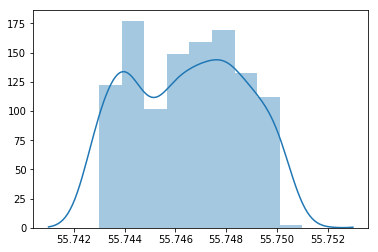

In [120]:
sns.distplot(atm1['atm_address_lat'].values)

In [122]:
atm1['atm_address_lat'].values.std()

0.0022179832495869095

In [124]:
atm2 = yes_atm_address[yes_atm_address['terminal_id'] == terminal1.index[2]]
atm2['atm_address_lat'].values.std()

0.0023385661827184435

In [135]:
atm3 = pd.concat([atm1, atm2])

In [ ]:
atm3 = pd.concat

In [140]:
atm1.shape, atm2.shape, atm3.shape

((552, 18), (533, 18), (1085, 18))

In [145]:
atm3.groupby('terminal_id')['atm_address_lat'].std()

terminal_id
25453    0.002220
76055    0.002341
Name: atm_address_lat, dtype: float64

#### Посмотрим дисперсии координат atm, сгруппированных по terminal_id

0.0049497474683093696

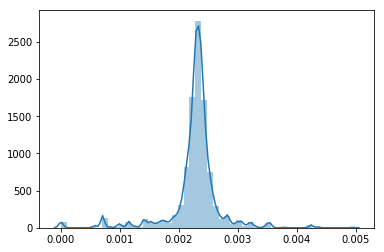

In [228]:
atm_lat = train[(train['atm_address'] != 0) & (train['atm_address_lat'] != 0)]
atm_lat_std = atm_lat.groupby('terminal_id')['atm_address_lat'].std()
atm_lat_std.dropna(inplace=True)
sns.distplot(atm_lat_std.values)
np.max(atm_lat_std.values)

0.0049497474683093696

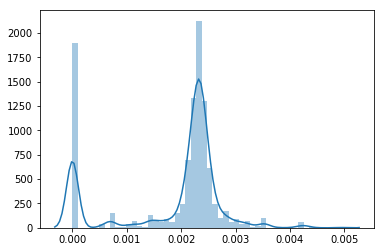

In [230]:
#atm_lat = train[(train['atm_address'] != 0) | (train['atm_address_lat'] != 0)]
atm_lat_std = atm_lat.groupby('terminal_id')['atm_address_lat'].std()
atm_lat_std.dropna(inplace=True)
sns.distplot(atm_lat_std.values)
np.max(atm_lat_std.values)

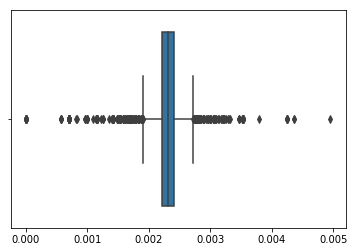

In [188]:
sns.boxplot(atm_lat_std.values)

In [175]:
np.max(atm_lat_std.values)

0.0049497474683093696

0.005656854249481709

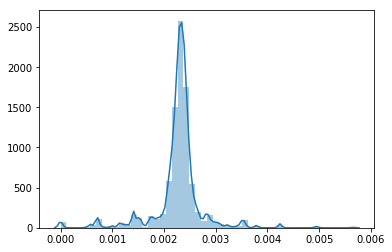

In [194]:
atm_lon = train[(train['atm_address'] != 0) & (train['atm_address_lon'] != 0)]
atm_lon_std = atm_lon.groupby('terminal_id')['atm_address_lon'].std()
atm_lon_std.dropna(inplace=True)
sns.distplot(atm_lon_std.values)
np.max(atm_lon_std.values)

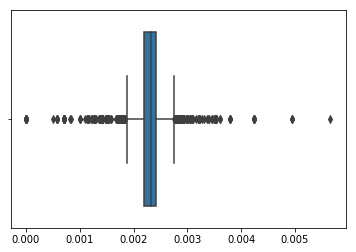

In [192]:
sns.boxplot(atm_lon_std.values)

#### Посмотрим дисперсии координат pos, сгруппированных по terminal_id

9.6301621114132701

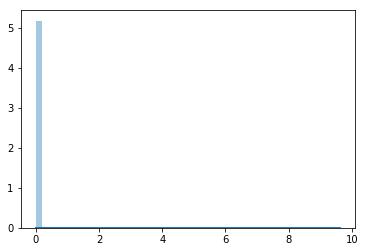

In [193]:
pos_lon = train[train['pos_address_lat'] != 0]
pos_lon_std = pos_lon.groupby('terminal_id')['pos_address_lat'].std()
pos_lon_std.dropna(inplace=True)
sns.distplot(pos_lon_std.values)
np.max(pos_lon_std.values)

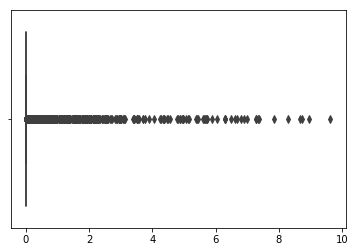

In [196]:
sns.boxplot(pos_lon_std.values)

In [210]:
pos_lon_std[pos_lon_std>0.005].sort_values(ascending=False)

terminal_id
139473    9.630162
128406    8.949119
90019     8.727334
49079     8.686062
74462     8.298649
10372     7.859146
188098    7.381138
9967      7.331340
111160    7.272406
69219     7.272406
68048     7.001642
99550     6.899210
11174     6.793792
25741     6.693132
182959    6.628886
131508    6.504637
11411     6.300641
140964    6.298088
50562     6.293544
77209     6.048592
26289     5.891718
105106    5.720874
141115    5.716816
70925     5.686362
119661    5.665980
119056    5.633181
81192     5.612220
101623    5.441797
80759     5.427336
20578     5.387051
            ...   
13160     0.034511
97633     0.026908
90925     0.026351
37595     0.025723
100240    0.025678
56415     0.022189
190291    0.021784
77215     0.021571
32320     0.019991
81287     0.019991
17121     0.019095
43711     0.018249
173411    0.018179
112849    0.016895
14157     0.015573
109150    0.015212
144603    0.014731
110813    0.013193
55266     0.013187
92827     0.011001
101640    0.009120


In [211]:
train[train['terminal_id'] == 139473]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
182927,3.265518,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,5812,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,139473,2017-08-17,NaN,NaN
182960,3.345149,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,7011,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,139473,2017-08-15,NaN,NaN
395361,3.006765,0,0.0,0.0,SYKTYVKAR,RUS,643.0,8095,61.681,50.827,5533,51 MOROZOVA STR BLDSYKTYVKAR167000 RUSRUS,61.666968,50.790304,139473,2017-09-04,61.667,50.845
395365,2.572953,0,0.0,0.0,SYKTYVKAR,RUS,643.0,8095,61.681,50.827,5533,51 MOROZOVA STR BLDSYKTYVKAR167000 RUSRUS,61.666968,50.790304,139473,2017-07-12,61.667,50.845
565527,3.265886,0,0.0,0.0,SYKTYVKAR,RUS,643.0,6747,61.791,50.748,5533,51 MOROZOVA STR BLDSYKTYVKAR167000 RUSRUS,61.666968,50.790304,139473,2017-05-24,NaN,NaN
735369,2.531228,0,0.0,0.0,SOCHI,RUS,643.0,5472,55.710,37.398,7011,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,139473,2017-04-24,NaN,NaN
874612,3.335530,0,0.0,0.0,SYKTYVKAR,RUS,643.0,1483,61.746,50.770,5533,51 MOROZOVA STR BLDSYKTYVKAR167000 RUSRUS,61.666968,50.790304,139473,2017-10-01,NaN,NaN


In [234]:
train['pos_address'][train['terminal_id'] == 139473].unique()

array(['G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000    RUSRUS',
       '51 MOROZOVA STR BLDSYKTYVKAR167000    RUSRUS'], dtype=object)

In [235]:
train[train['pos_address'] == train['pos_address'][train['terminal_id'] == 139473].unique()[0]]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
182868,3.471806,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,5812,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,60383,2017-08-17,NaN,NaN
182894,3.444078,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,7011,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,77823,2017-08-13,NaN,NaN
182897,3.524388,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,7011,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,102180,2017-08-13,NaN,NaN
182904,3.322407,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,5814,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,71409,2017-08-17,NaN,NaN
182907,4.936152,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,7011,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,25741,2017-08-11,NaN,NaN
182927,3.265518,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,5812,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,139473,2017-08-17,NaN,NaN
182932,3.335323,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,5812,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,145133,2017-08-18,NaN,NaN
182944,3.078306,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,5812,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,166770,2017-08-11,NaN,NaN
182956,3.511552,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,7011,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,77823,2017-08-17,NaN,NaN
182960,3.345149,0,0.0,0.0,SOCHI,RUS,643.0,3289,55.842,37.355,7011,"G. SOCHI, UL. LENINGRADSKAJA, 7SOCHI354000 ...",43.650585,39.656114,139473,2017-08-15,NaN,NaN


In [254]:
pos = train[train['pos_address'] == train['pos_address'][train['terminal_id'] == 139473].unique()[0]]
pos['terminal_id'][:5]

182868     60383
182894     77823
182897    102180
182904     71409
182907     25741
Name: terminal_id, dtype: int64

In [248]:
pos['terminal_id'].values[0]

60383

In [252]:
pos['atm_address_lat']

182868    0.0
182894    0.0
182897    0.0
182904    0.0
182907    0.0
182927    0.0
182932    0.0
182944    0.0
182956    0.0
182960    0.0
183011    0.0
183034    0.0
183042    0.0
471742    0.0
471746    0.0
471747    0.0
471752    0.0
471753    0.0
471758    0.0
471763    0.0
471764    0.0
735329    0.0
735332    0.0
735334    0.0
735341    0.0
735343    0.0
735355    0.0
735359    0.0
735369    0.0
735383    0.0
Name: atm_address_lat, dtype: float64

In [256]:
pos['pos_address_lat'][pos['pos_address_lat'].index[0]]

43.650584500000001

In [257]:
pos['pos_address_lon'][pos['pos_address_lon'].index[0]]

39.656113700000013

In [255]:
# 139473
c = 1
#city = yes_atm_address['city'][yes_atm_address['terminal_id'] == terminal1.index[c]].unique()[0]
city = 'G. SOCHI, UL. LENINGRADSKAJA'
location = geolocator.geocode(city)

m = folium.Map(location=[location.latitude, location.longitude], zoom_start=10)

pos = train[train['pos_address'] == train['pos_address'][train['terminal_id'] == 139473].unique()[0]]

for i in range(pos.shape[0]):
    pos_lat = pos['pos_address_lat'][pos['pos_address_lat'].index[i]]
    pos_lon = pos['pos_address_lon'][pos['pos_address_lon'].index[i]]
    t = pos['terminal_id'].values[i]
    m = pos['mcc'].values[i]

    folium.Marker([pos_lat, pos_lon], popup='t' + str(t) + ' ' + 'mcc' + str(m), icon=folium.Icon(color='blue', icon='usd')).add_to(m)

m


AttributeError: 'numpy.int64' object has no attribute 'add_child'

In [212]:
train[train['terminal_id'] == 11174]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
247276,2.775268,0,0.0,0.0,SARANSK,RUS,643.0,7047,54.168,45.189,7542,"UL. VOLGOGRADSKAYA, D. 71SARANSK430009 RUS",54.185658,45.216281,11174,2017-08-31,NaN,NaN
344802,3.102027,0,0.0,0.0,SEVASTOPOL,RUS,643.0,1707,45.033,38.996,5999,"KOSAREVA, 1SEVASTOPOL299006 RUSRUS",44.577785,33.462047,11174,2017-05-24,NaN,NaN


##### проверить в тесте этот косяк, терминалы с разными координатами и адресами

In [216]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265470 entries, 0 to 1265469
Data columns (total 14 columns):
amount              1265470 non-null float64
atm_address         1265470 non-null object
atm_address_lat     1265470 non-null float64
atm_address_lon     1265470 non-null float64
city                1265462 non-null object
country             1265470 non-null object
currency            1265469 non-null float64
customer_id         1265470 non-null int64
mcc                 1265470 non-null object
pos_address         1265470 non-null object
pos_address_lat     1265470 non-null float64
pos_address_lon     1265470 non-null float64
terminal_id         1265454 non-null object
transaction_date    1265469 non-null object
dtypes: float64(6), int64(1), object(7)
memory usage: 135.2+ MB


In [221]:
test1 = test.copy()

In [223]:
test1['terminal_id'].dropna(inplace=True)

13.344582637386138

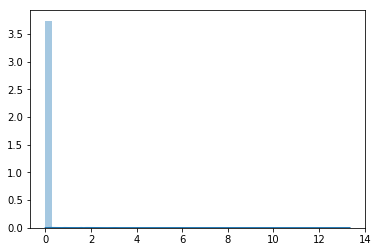

In [224]:
pos_lon = test1[test1['pos_address_lat'] != 0]
pos_lon_std = pos_lon.groupby('terminal_id')['pos_address_lat'].std()
pos_lon_std.dropna(inplace=True)
sns.distplot(pos_lon_std.values)
np.max(pos_lon_std.values)

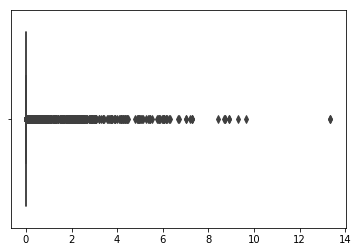

In [225]:
sns.boxplot(pos_lon_std.values)

0.0056568542494992938

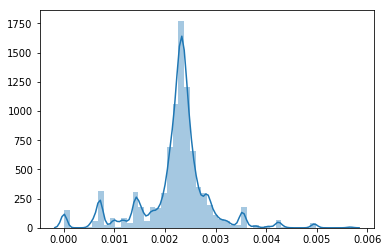

In [226]:
atm_lon = test1[(test1['atm_address'] != 0) & (test1['atm_address_lon'] != 0)]
atm_lon_std = atm_lon.groupby('terminal_id')['atm_address_lon'].std()
atm_lon_std.dropna(inplace=True)
sns.distplot(atm_lon_std.values)
np.max(atm_lon_std.values)

0.0056568542494992938

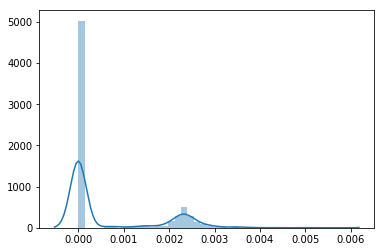

In [227]:
atm_lon = test1[(test1['atm_address'] != 0) | (test1['atm_address_lon'] != 0)]
atm_lon_std = atm_lon.groupby('terminal_id')['atm_address_lon'].std()
atm_lon_std.dropna(inplace=True)
sns.distplot(atm_lon_std.values)
np.max(atm_lon_std.values)

в тесте тоже такая штука есть, так что надо автоматизировать это дело

In [232]:
train[train['terminal_id'] == 128406]

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
52363,2.018420,0,0.0,0.0,ZHELEZNODOROZ,RUS,643.0,7734,55.727,38.034,5411,15 KALININA STRZHELEZNODOROZ143980 RUSRUS,55.742107,38.029630,128406,2017-05-03,NaN,NaN
855391,4.316067,0,0.0,0.0,KRASNOGORSK,RUS,643.0,1588,47.139,39.757,5699,"UL.MEZHDUNARODNAJA, D.8KRASNOGORSK143400 RU...",43.086142,44.633731,128406,2017-08-27,57.796,52.681
